# Task 3

In [109]:
import numpy as np
import matplotlib.pyplot as plt
import math
import re
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
import scipy.io as sio
plt.rcParams['figure.figsize'] = 10,10

import sklearn.datasets
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

## Original Data

In [110]:
my_iris_data = sklearn.datasets.load_iris()
print ("my_iris_data.data.shape:",my_iris_data.data.shape)
print ("labels:",my_iris_data.target)

my_iris_data.data.shape: (150, 4)
labels: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2]


In [111]:
X_train = np.concatenate((my_iris_data.data[10:50,:],my_iris_data.data[60:100,:], my_iris_data.data[110:150,:]))
X_train = np.concatenate((np.ones((X_train.shape[0],1)),X_train),axis=1) # Append bias term 1
y_train = np.concatenate((my_iris_data.target[10:50],my_iris_data.target[60:100], my_iris_data.target[110:150]))
print ("X_train.shape:", X_train.shape)
print ("y_train.shape:", y_train.shape)

X_test = np.concatenate((my_iris_data.data[40:50,:],my_iris_data.data[90:100,:], my_iris_data.data[140:150,:]))
X_test = np.concatenate((np.ones((X_test.shape[0],1)),X_test),axis=1) # Append bias term 1
y_test = np.concatenate((my_iris_data.target[40:50],my_iris_data.target[90:100], my_iris_data.target[140:150]))
print ("X_test.shape:", X_test.shape)
print ("y_test.shape:", y_test.shape)

X_train.shape: (120, 5)
y_train.shape: (120,)
X_test.shape: (30, 5)
y_test.shape: (30,)


## Preprocess the labels to get 3 datasets

In [112]:
y_train1 = np.copy(y_train); y_test1 = np.copy(y_test)
y_train2 = np.copy(y_train); y_test2 = np.copy(y_test)
y_train3 = np.copy(y_train); y_test3 = np.copy(y_test)

y_train1[y_train == 1] = -1
y_train1[y_train == 2] = -1
y_train1[y_train == 0] = 1
y_test1[y_test == 1] = -1
y_test1[y_test == 2] = -1
y_test1[y_test == 0] = 1

y_train2[y_train == 1] = 1
y_train2[y_train == 2] = -1
y_train2[y_train == 0] = -1
y_test2[y_test == 1] = 1
y_test2[y_test == 2] = -1
y_test2[y_test == 0] = -1

y_train3[y_train == 1] = -1
y_train3[y_train == 2] = 1
y_train3[y_train == 0] = -1
y_test3[y_test == 1] = -1
y_test3[y_test == 2] = 1
y_test3[y_test == 0] = -1

## Task3: Softmax on iris

Original target function: 

$$ L({\bf w}_1, \dots, {\bf w}_K, b_1, \dots, b_K) = -\sum_{i} \ln p_{y^{(i)}} + \frac{\lambda}{2} \sum_{k=1}^{K}\left \| {\bf w}_k \right \|^2. \nonumber $$

$$ \text{where } p_j = p(y=j|{\bf x})=\frac{e^{f_j}}{\sum_{k=1}^{K}{e^{f_k}}}\nonumber; f_j =\mathbf{w}_j \cdot {\bf x}+b_j $$

The gradient w.r.t $\textbf{w}$ of the target function:

$$ \frac{d L({\bf w}_1, \dots, {\bf w}_K, b_1, \dots, b_K)}{d \textbf{w}_k} = \lambda \textbf{w}_k + \sum_{i,y_i=k}(p(k|{\bf x}_i)-1){\bf x}_i+\sum_{i,y_i\neq k}p(k|{\bf x}_i){\bf x}_i.$$

$$ \frac{d L({\bf w}_1, \dots, {\bf w}_K, b_1, \dots, b_K)}{d b_k} = \sum_{i,y_i=k}(p(k|{\bf x}_i)-1)+\sum_{i,y_i\neq k}p(k|{\bf x}_i).$$

In [113]:
lamb=0.001 # Set the lambda for task3
learning_rate = 0.0001 # the alpha
n_iter = 20000
iterations = []

In [114]:
def softmax_P(X, W, b):
    f         = W.dot(X.T) + b   # Shape: [K,n].
    f         = f - f.max(axis=0, keepdims=True)  # Avoid the big number 
    exp_f     = np.exp(f)        # Shape: [K,n].
    sum_exp_f = exp_f.sum(axis=0, keepdims=True)  # Shape: [1,n].
    P         = (exp_f / sum_exp_f).T
    return P

In [115]:
# gradient of loss function L(w)
# shape X (120, 5)
# Y (120,)
# W (3, 5)
# b (3, 1)
# P (120, 3)

def L_prime(X, Y, W, b):
    dL_by_dW = np.zeros_like(W)
    dL_by_db = np.zeros_like(b)

    P = softmax_P(X, W, b)
    for k in range(W.shape[0]):
        for i in range(X.shape[0]):
            if Y[i] == k:
                dL_by_dW[k,:] += (P[i,k] - 1) * X[i]
                dL_by_db[k,:] += (P[i,k] - 1)
            else:
                dL_by_dW[k,:] += (P[i,k]) * X[i]
                dL_by_db[k,:] += (P[i,k])
        dL_by_dW[k,:] += lamb * W[k]
    return dL_by_dW, dL_by_db

In [116]:
def L(X, Y, W, b):
    loss_sum = 0
    l2_sum = 0

    P = softmax_P(X, W, b)
    loss_sum = np.sum(np.log(P[range(Y.shape[0]), Y]))
    for k in range(W.shape[0]):
        l2_sum += np.dot(W[k].T, W[k])
    L = (lamb/2) * l2_sum - loss_sum
    return L

### (Warning! The next cell takes time to finish descending!)

In [117]:
K = 3

# NOTE: Shape of w matrix is different from Task 2!
w = np.zeros((K, X_train.shape[1]))
b = np.zeros((K,1))   # Bias vector.

# We will keep track of training loss over iterations
iterations = [0]
L_list = [L(X_train, y_train, w, b)]
for i in range(n_iter):
    gradient_w, gradient_b = L_prime(X_train, y_train, w, b)
    w_new = w - learning_rate * gradient_w
    b_new = b - learning_rate * gradient_b
    iterations.append(i+1)
    L_list.append(L(X_train, y_train, w_new, b_new))

    if (np.linalg.norm(w_new - w, ord = 1) + np.linalg.norm(b_new - b, ord = 1)) < 0.0005:
        print("gradient descent has converged after " + str(i) + " iterations")
        break
    if i % 1000 == 0:
        print(i, np.linalg.norm(w_new - w, ord = 1) + np.linalg.norm(b_new - b, ord = 1), L_list[-1])
    w = w_new
    b = b_new
print ("w vector: \n" + str(w))
print ("b vector: \n" + str(b))

0 0.018133333333333345 130.0969308576614
1000 0.0015265961323854133 40.64964008483113
2000 0.001045789989105983 30.64391021867177
3000 0.0008003824640225449 25.49768315357868
4000 0.0006503421506856566 22.330647367977292
5000 0.0005493829092290264 20.171031921771363
gradient descent has converged after 5648 iterations
w vector: 
[[ 0.34088882  0.69679479  1.7436896  -2.4429943  -1.12047121]
 [ 0.5044756   0.53289235 -0.32021087  0.01421838 -0.99473911]
 [-0.84536442 -1.22968715 -1.42347872  2.42877592  2.11521032]]
b vector: 
[[ 0.34102611]
 [ 0.50463694]
 [-0.84566305]]


### Results on Training set

In [118]:
prediction = np.argmax(np.dot(X_train, w.T) + b.T,axis=1)
training_accuracy = (prediction - y_train == 0)

print ("The training accuracy:", np.sum(training_accuracy)*1.0/X_train.shape[0]*100, "%.")

The training accuracy: 97.5 %.


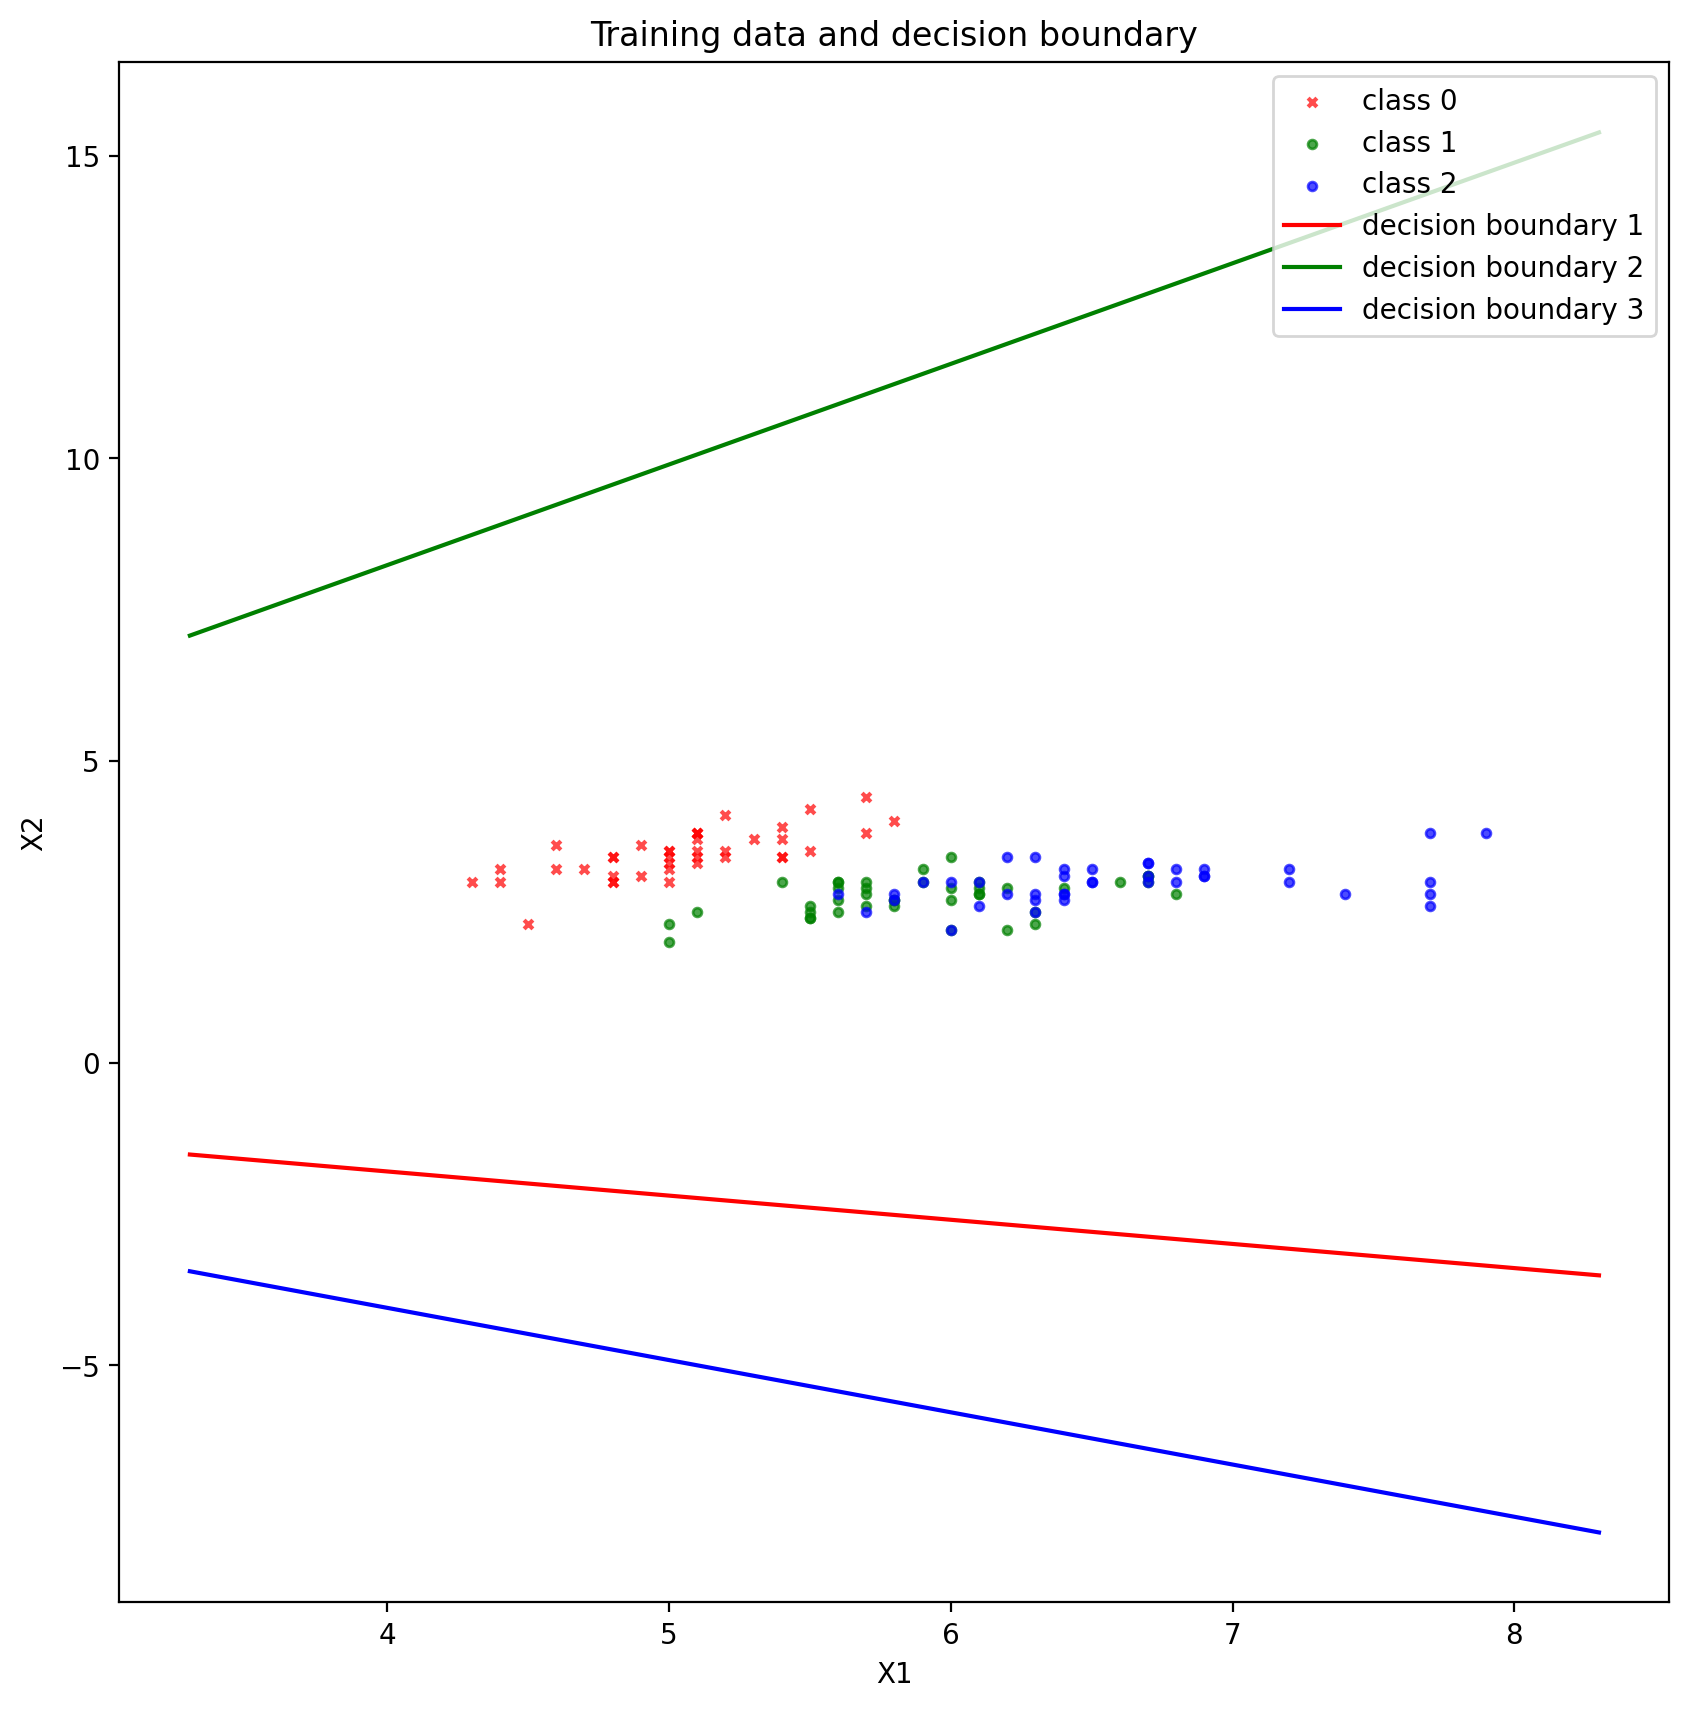

In [119]:
x1 = 1; x2 = 2

x = np.arange(np.min(X_train[:,x1])-1,np.max(X_train[:,x1])+1,1.0)
y1 = (-b[0][0]-w[0][1]*x)/w[0][2]
y2 = (-b[1][0]-w[1][1]*x)/w[1][2]
y3 = (-b[2][0]-w[2][1]*x)/w[2][2]

plt.scatter(X_train[y_train==0, x1], X_train[y_train==0, x2], marker='x', color='r', alpha=0.7, s=10, label='class 0')
plt.scatter(X_train[y_train==1, x1], X_train[y_train==1, x2], marker='o', color='g', alpha=0.7, s=10, label='class 1')
plt.scatter(X_train[y_train==2, x1], X_train[y_train==2, x2], marker='o', color='b', alpha=0.7, s=10, label='class 2')

plt.xlabel('X1')
plt.ylabel('X2')
plt.plot(x,y1, color='r', label='decision boundary 1')
plt.plot(x,y2, color='g', label='decision boundary 2')
plt.plot(x,y3, color='b', label='decision boundary 3')
plt.title('Training data and decision boundary')

plt.legend(loc='upper right', fontsize=10)

### Results on Test set

In [120]:
prediction = np.argmax(np.dot(X_test, w.T) + b.T, axis=1)

testing_accuracy = np.sum(prediction == y_test)*1.0/X_test.shape[0]
print ("The test accuracy: ", testing_accuracy*100, "%.")

The test accuracy:  100.0 %.
